# Train

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.2483 - loss: 5.8913 - val_accuracy: 0.2627 - val_loss: 3.2455 - learning_rate: 0.0010
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.3247 - loss: 3.2390 - val_accuracy: 0.3816 - val_loss: 2.8480 - learning_rate: 0.0010
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3919 - loss: 2.7132 - val_accuracy: 0.6129 - val_loss: 2.2459 - learning_rate: 0.0010
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.5498 - loss: 2.1283 - val_accuracy: 0.6914 - val_loss: 1.6994 - learning_rate: 0.0010
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6773 - loss: 1.6182 - val_accuracy: 0.7524 - val_loss: 1.2880 - learning_rate: 0.0010
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7686 - loss: 1.2624 - val_accuracy: 0.8182 - val_loss: 1.0569 - learning_rate: 0.0010
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8100 - los

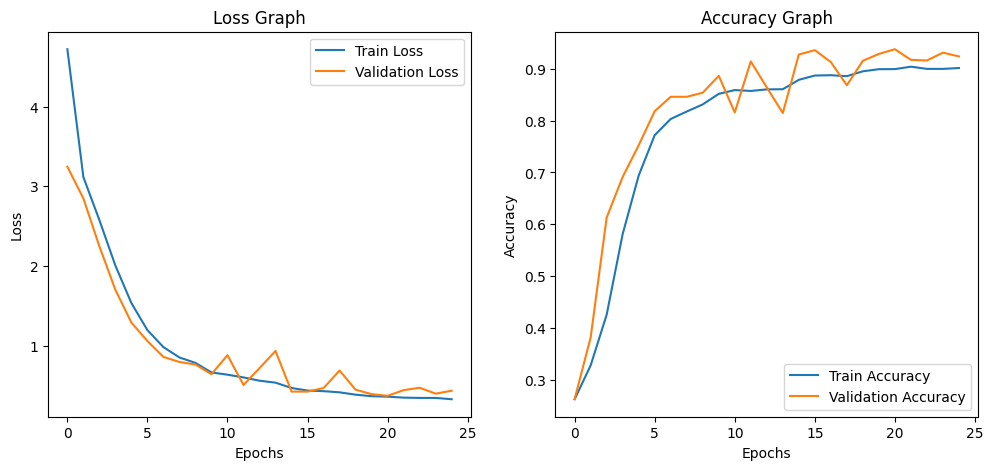

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# โหลดข้อมูล
df = pd.read_csv('train_augmented2.csv')

# Tokenization & Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

vocab_size = len(tokenizer.word_index) + 1
max_length = 32
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# จัดการ Label (One-Hot Encoding)
label_order = ['minimum', 'mild', 'moderate', 'severe']
labels = pd.Categorical(df['label'], categories=label_order, ordered=True)
labels = pd.get_dummies(labels).values

# แบ่งข้อมูล Train-Test (80:20)
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# สร้างโมเดล LSTM
model = Sequential([
    Embedding(vocab_size, 128),
    Dropout(0.4),
    Bidirectional(LSTM(48, return_sequences=True, kernel_regularizer=l1_l2(0.001, 0.002))),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(24, kernel_regularizer=l1_l2(0.001, 0.002)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=l1_l2(0.001, 0.005)),
    Dropout(0.6),
    Dense(labels.shape[1], activation='softmax')
])

# คอมไพล์โมเดล
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# ใช้ ReduceLROnPlateau และ EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# เทรนโมเดล
history = model.fit(
    x_train, y_train,
    epochs=50, batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# ประเมินผลลัพธ์
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(classification_report(y_test_classes, y_pred_classes, target_names=label_order))

# วาดกราฟ Loss และ Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

plt.show()


In [ ]:
model.save('model.h5')

In [ ]:
import pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Test

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import classification_report

# โหลดโมเดล
model = load_model('model.h5')

# โหลด Tokenizer ที่ใช้ตอน Train
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# โหลด test.csv
df_test = pd.read_csv('test_augmented2.csv')

# ใช้ Tokenizer เดิมในการแปลงข้อความเป็นลำดับตัวเลข
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

# Padding ให้มีขนาดเท่ากับที่ใช้ตอนเทรน
max_length = 32
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

# กำหนดลำดับของ Label ให้ตรงกับตอน Train
label_order = ['minimum', 'mild', 'moderate', 'severe']
labels_test = pd.Categorical(df_test['label'], categories=label_order, ordered=True)
labels_test = pd.get_dummies(labels_test).values  # ทำ One-Hot Encoding ตามลำดับใหม่

# ทำนายผลลัพธ์
y_pred_test = model.predict(padded_sequences_test)

# แปลงเป็นคลาสที่มีค่าความน่าจะเป็นสูงสุด
y_pred_classes = np.argmax(y_pred_test, axis=1)
y_test_classes = np.argmax(labels_test, axis=1)

# แสดงผลความแม่นยำ
print(classification_report(y_test_classes, y_pred_classes, target_names=label_order))

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
              precision    recall  f1-score   support

     minimum       0.91      0.85      0.88       520
        mild       0.91      0.99      0.95       533
    moderate       0.95      0.93      0.94       513
      severe       0.95      0.96      0.96       504

    accuracy                           0.93      2070
   macro avg       0.93      0.93      0.93      2070
weighted avg       0.93      0.93      0.93      2070



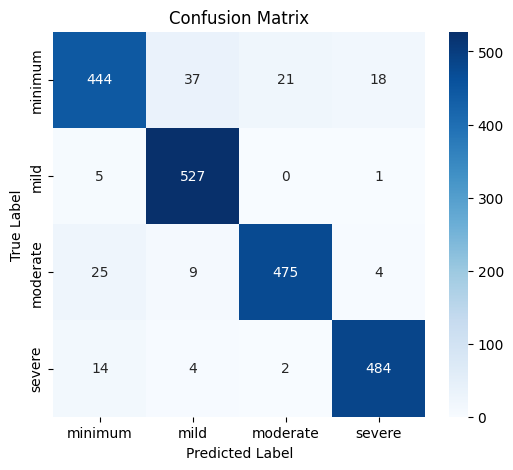

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# คำนวณ Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# แสดงผลเป็นตาราง
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_order, yticklabels=label_order)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# รวมข้อมูลต้นฉบับกับผลลัพธ์การทำนาย
df_test['predicted_label'] = [label_order[i] for i in y_pred_classes]

# แสดงตัวอย่างของแต่ละคลาสที่ถูกทำนาย
for label in label_order:
    print(f"\n🔹 ตัวอย่างข้อความที่ถูกทำนายเป็น '{label}':")
    examples = df_test[df_test['predicted_label'] == label]['text'].head(5).tolist()  # ดึงตัวอย่าง 5 รายการ
    for i, text in enumerate(examples, 1):
        print(f"{i}. {text}")



🔹 ตัวอย่างข้อความที่ถูกทำนายเป็น 'minimum':
1. ? What if I am at a friends party and a man whispers in my ear that he likes to stare at me so he can touch himself later....but he is dating my friend and he knows I don’t want to upset her?? ? What if I am in the car with a man and some lady cuts him off and he gets road rage and says he wants to “drag her out of the car by her hair and cut her nipples off” but then later says he “obviously didn’t mean it”?? ?
2. When it is his weekend off). He grumbles and yells only on his 'nervous' days. Maybe once a week. Sometimes three days in a row. Sometimes it is two weeks of not yelling.
3. It's not that the current one isn't helping at all, but it would be nice if it helped _more_. She's got a lot of good literature and notes and it's helped some. But it's her words that it hasn't helped as much as she would like. Just wondering if anyone with any experience in talk therapy would share anything she may be able to talk about or focus on that c

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle

# โหลด Tokenizer ที่เคยใช้ตอนเทรน
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# โหลดโมเดลที่ฝึกไว้
model = load_model('model.h5')

# กำหนดค่าความยาวสูงสุดของ sequence
max_length = 32

# ฟังก์ชันทำนาย sentiment จากข้อความอินพุต
def predict_sentiment(input_text):
    # แปลงข้อความเป็นตัวเลข
    input_sequence = tokenizer.texts_to_sequences([input_text])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=max_length, padding='post')

    # ทำนายผลลัพธ์
    prediction = model.predict(padded_input_sequence)

    # แปลงค่าผลลัพธ์เป็น label ตามลำดับที่ถูกต้อง
    sentiment_labels = ['minimum', 'mild', 'moderate', 'severe']  # ✅ แก้ลำดับให้ตรงกับที่ใช้ใน One-Hot Encoding
    predicted_label_index = np.argmax(prediction)
    predicted_sentiment = sentiment_labels[predicted_label_index]

    return predicted_sentiment

# รับอินพุตจากผู้ใช้
user_input = input("Enter a sentence: ")
predicted_sentiment = predict_sentiment(user_input)
print("Predicted Sentiment:", predicted_sentiment)
